In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Load the preprocessed data
def load_cleaned_data(file_to_load):
    return pd.read_csv(file_to_load, sep='\t')

In [5]:
# Split the data into train and test portions
def split(X, y):
  # 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

# Adding both TF and CountVectorizer

* CountVectorizer() → raw word counts

* TfidfVectorizer() → weighted terms


In [6]:
def tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf

def count_vectorizer(X_train, X_test):
    vectorizer = CountVectorizer(stop_words='english', max_features=10000)
    X_train_counts = vectorizer.fit_transform(X_train)
    X_test_counts = vectorizer.transform(X_test)
    return X_train_counts, X_test_counts

In [7]:
# Uses MultinomialNB for the baseline model
def naive_bayes(X_train_tfidf, X_test_tfidf, y_train):
  model = MultinomialNB()
  model.fit(X_train_tfidf, y_train)
  y_pred = model.predict(X_test_tfidf)
  return model, y_pred

In [13]:
# get the metrics for accuracy, precision, recall, f1 and roc curve
def metrics(model, X_test, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_pred, average='binary')
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_pred, average='binary')
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_pred)
    print(f"F1: {f1:.2f}")

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2, label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Hyperpartisan Classification')
    plt.legend()
    plt.show()


# Comparison approach (Updt. 4/1/2025)
1. Store the evaluation scores for both methods instead of just printing them.

2. Compare the results (e.g., based on F1-score or AUC, depending on what you value more).



--- TF-IDF ---
Accuracy: 0.65
Precision: 0.80
Recall: 0.08
F1: 0.15


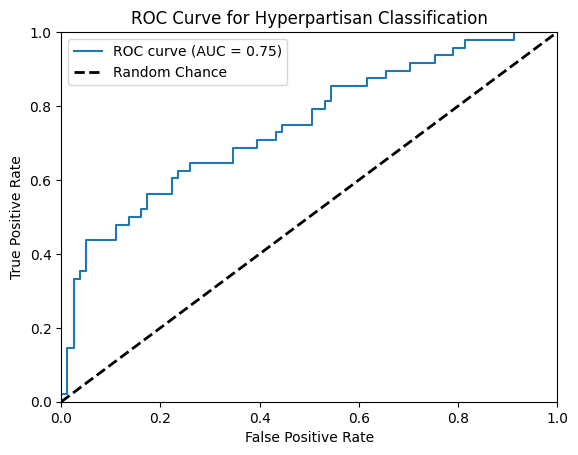


--- CountVectorizer ---
Accuracy: 0.69
Precision: 0.57
Recall: 0.71
F1: 0.63


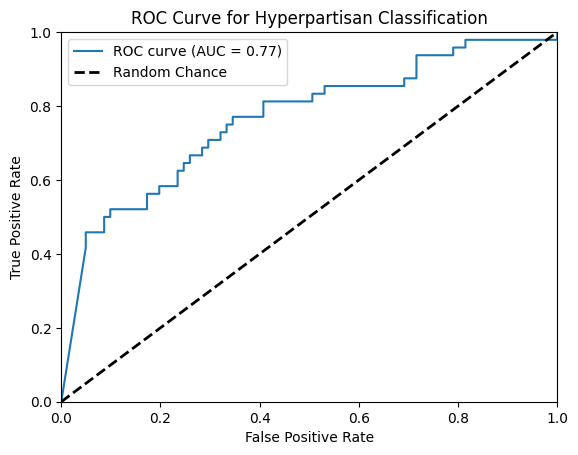


=== Comparison Table ===
                 Accuracy  Precision  Recall  F1 Score    AUC
TF-IDF              0.651      0.800   0.083     0.151  0.746
CountVectorizer     0.690      0.567   0.708     0.630  0.765


In [14]:
# Load the data
data = load_cleaned_data("data/byarticle_clean.tsv") #../
X = data['full_text']
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = split(X, y)

# Store results for summary
results = {}

# Vectorization methods
vectorizers = {
    "TF-IDF": tfidf,
    "CountVectorizer": count_vectorizer
}

# Run Naive Bayes for each vectorizer
for name, vectorizer_fn in vectorizers.items():
    X_train_vec, X_test_vec = vectorizer_fn(X_train, X_test)
    model, y_pred = naive_bayes(X_train_vec, X_test_vec, y_train)

    print(f"\n--- {name} ---")
    metrics(model, X_test_vec, y_test, y_pred)  # prints + plots ROC

    # Store for comparison table
    y_pred_proba = model.predict_proba(X_test_vec)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": auc(fpr, tpr)
    }

# Final comparison table
results_df = pd.DataFrame(results).T
print("\n=== Comparison Table ===")
print(results_df.round(3))


# Precision vs Recall Tradeoff(by-article):

    * TF-IDF has high precision but very low recall. It correctly identifies hyperpartisan articles when it predicts them, but misses most of them.

    * CountVectorizer has a much higher recall. It catches most of the hyperpartisan articles, but with slightly lower precision.

    * F1 is the harmonic mean of precision and recall. CountVectorizer has a far better F1 score (0.63 vs 0.15), indicating a more balanced performance.

    * Both perform decently on ROC-AUC, but CountVectorizer edges out with 0.77, meaning better separation between the classes.

    So ironically, TF-IDF removes signals that are actually useful in our task.